# Seminar: Differentiable modeling

Seminar is based on the some materials from paper "Wave physics as an analog recurrent neural network",  materials by Son, Sang-Kil and Chu, Shih-I from University of Kansas and materials from IGNNITION package.

Let's consider abstract wave propagating through medium. The dynamics of the scalar field
distribution, $u=u(x, y, z, t)$, are governed by the wave equation

$$\frac{\partial^2 u}{\partial t^2}-c^2 \cdot \nabla^2 u=f$$

where
$\nabla^2=\frac{\partial^2}{\partial x^2}+\frac{\partial^2}{\partial y^2}+\frac{\partial^2}{\partial z^2}$
is the Laplacian operator. $c=c(x, y, z)$ is the spatial distribution of
the wave speed and $f=f(x, y, z, t)$ is a source term.  Previous equation can be discretized in time using
centered finite differences with a temporal step size of $\Delta t$,
after which it becomes

$$\frac{u_{t+1}-2 u_t+u_{t-1}}{\Delta t^2}-c^2 \cdot \nabla^2 u_t=f_t$$

Here, the subscript $t$ is used to indicate the value of a scalar field
at a given time step.


Surprisingly, there is interesting analogy between explicit solver of this equation and RNN updating scheme! While many variations of RNNs exist, a common implementation is described by the following update equations

$$
\begin{gathered}
\boldsymbol{h}_t=\sigma^{(h)}\left(\boldsymbol{W}^{(h)} \cdot \boldsymbol{h}_{t-1}+\boldsymbol{W}^{(x)} \cdot \boldsymbol{x}_t\right) \\
\boldsymbol{y}_t=\sigma^{(y)}\left(\boldsymbol{W}^{(y)} \cdot \boldsymbol{h}_t\right)
\end{gathered}
$$

To connect wave equation updating scheme to the RNN update equations, we exress this in matrix form as

$$\left[\begin{array}{c}
u_{t+1} \\
u_t
\end{array}\right]=\left[\begin{array}{cc}
2+\Delta t^2 \cdot c^2 \cdot \nabla^2 & -1 \\
1 & 0
\end{array}\right] \cdot\left[\begin{array}{c}
u_t \\
u_{t-1}
\end{array}\right]+\Delta t^2 \cdot\left[\begin{array}{c}
f_t \\
0
\end{array}\right]$$

Then, the update equation for the wave equation can be
rewritten as

$$\begin{aligned}
& \boldsymbol{h}_t=\boldsymbol{A}\left(\boldsymbol{h}_{t-1}\right) \cdot \boldsymbol{h}_{t-1}+\boldsymbol{P}^{(\mathrm{i})} \cdot \boldsymbol{x}_t \\
& \boldsymbol{y}_t=\left|\boldsymbol{P}^{(\mathrm{o})} \cdot \boldsymbol{h}_t\right|^2
\end{aligned}$$

where we have defined $\boldsymbol{A}$ as the matrix.


Similar to the standard RNN, the connections between the hidden state and the input and output of the wave equation are also defined by linear operators, given by $\boldsymbol{P}^{(i)}$ and $\boldsymbol{P}^{(o)}$. These matrices define the injection and measuring points within the spatial domain. Unlike the standard RNN, where the input and output matrices are dense, the input and output matrices of the wave equation are sparse because they are nonzero only at the location of injection and measurement points. Moreover, these matrices are unchanged by the training process.

In this context, the "hidden state" is represented by the vector containing the values of the scalar field at two consecutive time steps:

$$\left[\begin{array}{c}
u_t \\
u_{t-1}
\end{array}\right]$$

This vector represents the information needed at time $t$ to determine the state at the next time step $t+1$, similar to how the hidden state in an RNN summarizes past information to predict the future.

## Wave solver for regular grids

### Task 1: Implement the Laplacian operator

The first task is to implement the discrete Laplacian operator using a convolution. You need to replace the placeholder in the `_laplacian` function with the correct code to calculate the Laplacian of the input tensor `y` using the given spatial step size `h`.

Recall the kernel for the 2D Laplacian operator using centered finite differences:

$$
\begin{bmatrix}
0 & 1 & 0 \\
1 & -4 & 1 \\
0 & 1 & 0
\end{bmatrix}
$$

Remember to scale the result by $\frac{1}{h^2}$ and handle the channel dimension required by `torch.nn.functional.conv2d`. You may find the documentation for `torch.nn.functional.conv2d` helpful.

Additionally, please implement impermeable boundary conditions (zero Neumann) using proper padding scheme of convolutions.

In [ ]:
import numpy as np
import torch

import torch
from torch.nn.functional import conv2d
from torch.nn.functional import pad

def _laplacian(y, h):
    """Laplacian operator with reflection padding for Neumann boundary conditions."""
    operator = h ** (-2) * torch.tensor([[[[0.0, 1.0, 0.0], [1.0, -4.0, 1.0], [0.0, 1.0, 0.0]]]], device=y.device, dtype=y.dtype)
    y = y.unsqueeze(1) # Add channel dimension

    # Explicitly apply reflection padding for zero Neumann boundary conditions
    # The padding amount is 1 on all sides (left, right, top, bottom)
    y_padded = pad(y, (1, 1, 1, 1), mode='reflect')

    # Apply convolution to the padded tensor with no additional padding (padding=0)
    return conv2d(y_padded, operator, padding=0).squeeze(1) # Remove channel dimension

### Task 2: Implement the time step update for the wave equation (explicit scheme, using torch)

In [ ]:
def _time_step(c, y1, y2, dt, h):
    """Perform a single time step update for the wave field without damping.
    c: The wave speed distribution.
    y1: The scalar wave field at the current time step
    y2: The scalar wave field at the previous time step
    dt: The temporal step size
    h: The spatial step size."""
    y = 2 * y1 - y2 + torch.mul(dt**2 * c.pow(2), _laplacian(y1, h))
    return y

### Task 3: Implement the TimeStep class, especially backward method of computational graph (manually).

In [ ]:
class TimeStep(torch.autograd.Function):
    @staticmethod
    def forward(ctx, c, y1, y2, dt, h):
        # This line saves the input tensors (c, y1, y2, dt, h) to the ctx context object.
        # These saved tensors will be available in the backward method when PyTorch calculates the gradients during backpropagation.
        ctx.save_for_backward(c, y1, y2, dt, h)
        return _time_step(c, y1, y2, dt, h)

    @staticmethod
    def backward(ctx, grad_output):
        c, y1, y2, dt, h = ctx.saved_tensors

        grad_c = grad_y1 = grad_y2 = grad_dt = grad_h = None

        # grad_output: This is the incoming gradient from the next layer in the computation graph (the gradient of the loss with respect to the output of this TimeStep).
        # The chain rule of calculus dictates that to find the gradient of the loss with respect to some input variable,
        # we multiply the incoming gradient (grad_output) by the gradient of the TimeStep's output with respect to this variable.

        if ctx.needs_input_grad[0]: # c
            grad_c = 2 * c * dt**(2) * _laplacian(y1, h) * grad_output
        if ctx.needs_input_grad[1]: # y1
            c2_grad = c.pow(2) * grad_output
            grad_y1 = dt**(2) * _laplacian(c2_grad, h) + 2 * grad_output
        if ctx.needs_input_grad[2]: # y2
            grad_y2 = -grad_output

        return grad_c, grad_y1, grad_y2, grad_dt, grad_h

In [ ]:
import numpy as np
import torch

import torch
from torch.nn.functional import conv2d
from torch.nn.functional import pad

def to_tensor(x, dtype=None):
  dtype = dtype if dtype is not None else torch.get_default_dtype()
  if type(x) is np.ndarray:
    return torch.from_numpy(x).type(dtype=dtype)
  else:
    return torch.tensor(x, dtype=dtype)


class WaveCell(torch.nn.Module):
    """The recurrent neural network cell implementing the scalar wave equation without damping"""

    def __init__(self,
                 dt : float,
                 geometry):

        super().__init__()

        # Set values
        self.register_buffer("dt", to_tensor(dt))
        self.geom = geometry


        # Validate inputs
        cmax = self.geom.cmax
        h = self.geom.h

        if dt > 1 / cmax * h / np.sqrt(2):
            raise ValueError(
                'The spatial discretization defined by the geometry `h = %f` and the temporal discretization defined by the model `dt = %f` do not satisfy the CFL stability criteria' % (
                h, dt))

    def parameters(self, recursive=True):
        for param in self.geom.parameters():
            yield param

    def forward(self, h1, h2, c):
        """Take a step through time

        Parameters
        ----------
        h1 :
            Scalar wave field one time step ago (part of the hidden state)
        h2 :
            Scalar wave field two time steps ago (part of the hidden state)
        c :
            Scalar wave speed distribution (this gets passed in to avoid generating it on each time step, saving memory for backprop)
        """

        y = TimeStep.apply(c, h1, h2, self.dt, self.geom.h)

        return y, h1

In [ ]:
import torch


class WaveRNN(torch.nn.Module):
        def __init__(self, cell, sources, probes=[]):

                super().__init__()

                self.cell = cell

                if type(sources) is list:
                        self.sources = torch.nn.ModuleList(sources)
                else:
                        self.sources = torch.nn.ModuleList([sources])

                if type(probes) is list:
                        self.probes = torch.nn.ModuleList(probes)
                else:
                        self.probes = torch.nn.ModuleList([probes])

        def forward(self, x, output_fields=False):
                """Propagate forward in time for the length of the inputs

                Parameters
                ----------
                x :
                        Input sequence(s), batched in first dimension
                output_fields :
                        Override flag for probe output (to get fields)
                """

                # Hacky way of figuring out if we're on the GPU from inside the model
                # Safely get device even if there are no parameters
                try:
                    device = "cuda" if next(self.parameters()).is_cuda else "cpu"
                except StopIteration:
                    # If there are no parameters, assume CPU or infer from input if possible
                    # For this case, let's assume CPU if no parameters.
                    device = "cpu"


                # First dim is batch
                batch_size = x.shape[0]

                # Init hidden states
                hidden_state_shape = (batch_size,) + self.cell.geom.domain_shape
                h1 = torch.zeros(hidden_state_shape, device=device)
                h2 = torch.zeros(hidden_state_shape, device=device)
                y_all = []

                # Because these will not change with time we should pull them out here to avoid unnecessary calculations on each
                # tme step, dramatically reducing the memory load from backpropagation
                c = self.cell.geom.c

                # Loop through time
                for i, xi in enumerate(x.chunk(x.size(1), dim=1)):

                        # Propagate the fields
                        h1, h2 = self.cell(h1, h2, c)

                        # Inject source(s)
                        for source in self.sources:
                                h1 = source(h1, xi.squeeze(-1)*self.cell.dt**2)


                        if len(self.probes) > 0 and not output_fields:
                                # Measure probe(s)
                                probe_values = []
                                for probe in self.probes:
                                        probe_values.append(probe(h1))
                                y_all.append(torch.stack(probe_values, dim=-1))
                        else:
                                # No probe, so just return the fields
                                y_all.append(h1)

                # Combine outputs into a single tensor
                y = torch.stack(y_all, dim=1)

                return y

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torch
import numpy as np

# Simple geometry, source, and probe classes
class SimpleGeometry(torch.nn.Module):
    def __init__(self, nx, ny, h, c_const):
        super().__init__()
        self.nx = nx
        self.ny = ny
        #self.h = h
        self.domain_shape = (nx, ny)
        self.c = torch.nn.Parameter(torch.full((nx, ny), c_const, dtype=torch.float32))
        self.register_buffer("h", torch.tensor(float(h), dtype=torch.get_default_dtype()))
        self.cmax = c_const


class PointSource(torch.nn.Module):
    def __init__(self, location):
        super().__init__()
        self.location = location

    def forward(self, field, input_signal):
        if field.ndim == 3:
             field[:, self.location[0], self.location[1]] += input_signal.squeeze(-1)
        else:
             field[self.location[0], self.location[1]] += input_signal.squeeze(-1)
        return field

class PointProbe(torch.nn.Module):
    def __init__(self, location):
        super().__init__()
        self.location = location

    def forward(self, field):
        if field.ndim == 3:
            return field[:, self.location[0], self.location[1]]
        else:
            return field[self.location[0], self.location[1]]

# Simulation parameters
nx, ny = 100, 100
h = 0.01
c_const = 1.5
dt = 0.5 * h / c_const / np.sqrt(2)
num_time_steps = 300

# Setup simulation components
geometry = SimpleGeometry(nx, ny, h, c_const)
wave_cell = WaveCell(dt, geometry)
source_location = (nx // 2, ny // 2)
probe_location = (nx // 6, ny // 6)
source = PointSource(source_location)
probe = PointProbe(probe_location)
wave_rnn = WaveRNN(wave_cell, sources=[source], probes=[probe])

# Generate source signal
source_input_signal = torch.sin(torch.linspace(0, 4 * torch.pi, num_time_steps)) * 0.5 * (1/dt ** 2)
source_input_signal = source_input_signal.unsqueeze(0) # Add batch dim
source_input_signal.requires_grad = True

print("Running simulation...")
# Run simulation and get full fields
simulation_output = wave_rnn(source_input_signal, output_fields=True)
wave_field_history_rnn = simulation_output[0].detach().numpy()
print("Simulation finished.")

# Visualization
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(wave_field_history_rnn[0], origin='lower', cmap='RdBu', vmin=-0.1, vmax=0.1, extent=[0, (nx-1)*h, 0, (ny-1)*h])
plt.colorbar(im, label='Amplitude')
ax.set_title('Wave propagation simulation')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal', adjustable='box')
ax.plot(source_location[1]*h, source_location[0]*h, 'wo', markersize=8, label='Source')
ax.plot(probe_location[1]*h, probe_location[0]*h, 'go', markersize=8, label='Probe')
ax.legend()

def animate(i):
    im.set_array(wave_field_history_rnn[i])
    ax.set_title(f'Time Step {i+1}')
    return [im]

print("Creating animation...")
ani = animation.FuncAnimation(fig, animate, frames=num_time_steps, interval=50, blit=True)
plt.close(fig)
display(HTML(ani.to_html5_video()))

Running simulation...
Simulation finished.
Creating animation...


In [ ]:
# test backpropagation after the regular grid simulation

final_wave_field = simulation_output[:, -1, :, :] # Shape [batch_size, nx, ny]

loss = final_wave_field.sum()

print(f"Calculated a simple loss: {loss.item()}")

try:
    loss.backward()
    print("Backward pass completed.")

except RuntimeError as e:
    print(f"Error during backward pass: {e}")
    print("Ensure that at least one tensor in the computation graph requires gradients for backward() to work.")

Calculated a simple loss: 3562.818115234375
Backward pass completed.


In [ ]:
print(source_input_signal.grad.min(), source_input_signal.grad.max())

tensor(5.5556e-06) tensor(0.0017)


In [ ]:
print(geometry.c.grad.min(), geometry.c.grad.max())

tensor(-4742.6514) tensor(1.3556)


### Task 4: Re-run with output-fields=False to output probe and print plot

In [ ]:
simulation_output = wave_rnn(source_input_signal, output_fields=False)

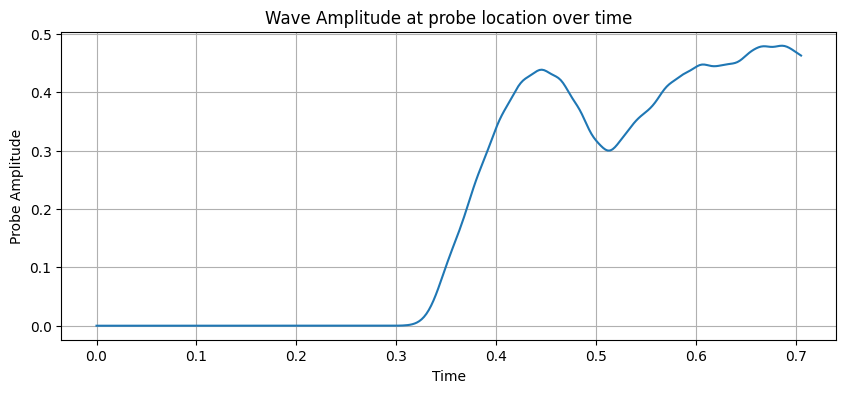

In [ ]:
probe_trace = simulation_output[0, :, 0].detach().numpy()
plt.figure(figsize=(10, 4))
plt.plot(np.arange(num_time_steps) * dt, probe_trace)
plt.xlabel('Time')
plt.ylabel('Probe Amplitude')
plt.title('Wave Amplitude at probe location over time')
plt.grid(True)
plt.show()

The scalar wave equation with damping is defined by the inhomogeneous partial differential equation:

$$
\frac{\partial^2 u}{\partial t^2}+2 b \cdot \frac{\partial u}{\partial t}=c^2 \cdot \nabla^2 u+f
$$

where $u$ is the unknown scalar field, $b$ is the damping coefficient. Here, we assume that $b$ can be spatially varying but is frequency-independent. For a time step indexed by $t$, equation is discretized using centered finite differences in time to give

$$
\frac{u_{t+1}-2 u_t+u_{t-1}}{\Delta t^2}+2 b \frac{u_{t+1}-u_{t-1}}{2 \Delta t}=c^2 \nabla^2 u_t+f_t
$$

Updating scheme with damping:

$$
u_{t+1}=\left(\frac{1}{\Delta t^2}+\frac{b}{\Delta t}\right)^{-1}\left[\frac{2}{\Delta t^2} u_t-\left(\frac{1}{\Delta t^2}-\frac{b}{\Delta t}\right) u_{t-1}+c^2 \cdot \nabla^2 u_t+f_t\right]
$$

In matrix form:

$$
\left[\begin{array}{c}
u_{t+1} \\
u_t
\end{array}\right]=\left[\begin{array}{cc}
\frac{2+\Delta t^2 \cdot c^2 \cdot \nabla^2}{1+\Delta t \cdot b} & \frac{\Delta t \cdot b - 1}{1+\Delta t \cdot b} \\
1 & 0
\end{array}\right] \cdot\left[\begin{array}{c}
u_t \\
u_{t-1}
\end{array}\right]+\left[\begin{array}{c}
\frac{\Delta t^2}{1 + \Delta t \cdot b} f_t \\
0
\end{array}\right]
$$

### Task 5: Implement simple damping function

Modify the `SimpleGeometry` class to include a simple damping coefficient `b`. This coefficient needs to be zero inside the square region defined by $0.2 \le x \le 0.8$ and $0.2 \le y \le 0.8$ (in normalized spatial coordinates, where the domain spans from 0 to 1 in both x and y directions based on `nx`, `ny`, and `h`). Outside this square, set a damping coefficient as non-zero value (for example, 0.5).

Remember that the spatial coordinates for a grid point $(i, j)$ can be calculated as $(i \cdot h, j \cdot h)$, where $i$ is the row index and $j$ is the column index.

In [ ]:
class SimpleGeometry(torch.nn.Module):
    def __init__(self, nx, ny, h, c_const, damping_value=0.5):
        super().__init__()
        self.nx = nx
        self.ny = ny
        #self.h = h
        self.domain_shape = (nx, ny)
        self.c = torch.nn.Parameter(torch.full((nx, ny), c_const, dtype=torch.float32))
        self.register_buffer("h", torch.tensor(float(h), dtype=torch.get_default_dtype()))
        self.cmax = c_const
        # Initialize spatially varying damping coefficient b
        b_buffer = torch.zeros((nx, ny))
        # Define the square region in grid coordinates
        x_min, x_max = int(0.2 * nx), int(0.8 * nx)
        y_min, y_max = int(0.2 * ny), int(0.8 * ny)

        # Set damping value outside the square region
        for i in range(nx):
            for j in range(ny):
                # Calculate normalized spatial coordinates
                normalized_x = i * h
                normalized_y = j * h
                if not (0.2 <= normalized_x <= 0.8 and 0.2 <= normalized_y <= 0.8):
                    b_buffer[i, j] = damping_value

        self.register_buffer("b", b_buffer)

### Task 6: Implement updating scheme for wave equation with damping based on earlier provided matrix form

In [ ]:
def _time_step_damping(b, c, y1, y2, dt, h):
    y = torch.mul((dt**-2 + b * dt**-1).pow(-1),
                  (2 / dt**2 * y1 - torch.mul((dt**-2 - b * dt**-1), y2)
                   + torch.mul(c.pow(2), _laplacian(y1, h)))
                  )
    return y

### Task 7: Implement a timeStep module with Automatic Differentiation

Create a new `torch.nn.Module` called `TimeStepDamping` that uses the `_time_step_damping` function. This class should allow PyTorch to automatically compute the gradients during the backward pass, so you do not need to implement a separate `backward` method like in the `TimeStep` class.

This module will represent a single time step of the damped wave equation within a PyTorch computation graph.

In [ ]:
import torch
import torch.nn as nn

class TimeStepDamping(nn.Module):
    def __init__(self):
        super().__init__()
        # No parameters to initialize in this simple module

    def forward(self, c, y1, y2, dt, h, b):
        """
        Perform a single time step update using the _time_step_damping function.

        Parameters
        ----------
        c : torch.Tensor
            The wave speed distribution.
        y1 : torch.Tensor
            The scalar wave field at the current time step (u_t).
        y2 : torch.Tensor
            The scalar wave field at the previous time step (u_{t-1}).
        dt : torch.Tensor or float
            The temporal step size.
        h : torch.Tensor or float
            The spatial step size.
        b : torch.Tensor
            The damping coefficient (can be spatially varying).

        Returns
        -------
        torch.Tensor
            The scalar wave field at the next time step (u_{t+1}).
        """
        y_next = _time_step_damping(b, c, y1, y2, dt, h)
        return y_next

**Question to think: do we really need this class? :)**

In [ ]:
import torch
import torch.nn as nn

class WaveCellDamping(torch.nn.Module):
    """
    The recurrent neural network cell implementing the scalar wave equation
    with optional damping, using TimeStepDamping for automatic differentiation.
    """

    def __init__(self,
                 dt : float,
                 geometry):

        super().__init__()

        # Set values
        self.register_buffer("dt", to_tensor(dt))
        self.geom = geometry

        # Initialize the TimeStepDamping module
        self.timestep_module = TimeStepDamping()

        # Validate inputs
        cmax = self.geom.cmax
        h = self.geom.h

        # The CFL condition with damping is more complex, but the undamped condition
        # is a reasonable first check.
        if dt > 1 / cmax * h / np.sqrt(2):
            print('Warning: The spatial discretization defined by the geometry `h = %f` and the temporal discretization defined by the model `dt = %f` may not satisfy the CFL stability criteria, especially with damping.' % (h, dt))


    def parameters(self, recursive=True):
        for param in self.geom.parameters():
            yield param

    def forward(self, h1, h2, c, b):
        """Take a step through time

        Parameters
        ----------
        h1 :
            Scalar wave field one time step ago (part of the hidden state), u_t
        h2 :
            Scalar wave field two time steps ago (part of the hidden state), u_{t-1}
        c :
            Scalar wave speed distribution
        b :
            Scalar damping distribution
        """

        # Use the TimeStepDamping module
        y = self.timestep_module(c, h1, h2, self.dt, self.geom.h, b)

        return y, h1

In [ ]:
import torch
import torch.nn as nn

# Assuming WaveCellDamping, sources, and probes are defined

class WaveRNNDamping(torch.nn.Module):
        def __init__(self, cell, sources, probes=[]):

                super().__init__()

                self.cell = cell
                # Validate that the cell's geometry has a 'b' attribute for damping
                if not hasattr(self.cell.geom, 'b'):
                     raise AttributeError("The provided cell's geometry does not have a 'b' attribute for damping.")


                if type(sources) is list:
                        self.sources = torch.nn.ModuleList(sources)
                else:
                        self.sources = torch.nn.ModuleList([sources])

                if type(probes) is list:
                        self.probes = torch.nn.ModuleList(probes)
                else:
                        self.probes = torch.nn.ModuleList([probes])

        def forward(self, x, output_fields=False):
                """Propagate forward in time for the length of the inputs

                Parameters
                ----------
                x :
                        Input sequence(s), batched in first dimension
                output_fields :
                        Override flag for probe output (to get fields)
                """

                # Hacky way of figuring out if we're on the GPU from inside the model
                # Safely get device even if there are no parameters
                try:
                    device = "cuda" if next(self.parameters()).is_cuda else "cpu"
                except StopIteration:
                    # If there are no parameters, assume CPU or infer from input if possible
                    # For this case, let's assume CPU if no parameters.
                    # A more robust way would be to infer from the input tensor 'x'
                    device = x.device if isinstance(x, torch.Tensor) else "cpu"


                # First dim is batch
                batch_size = x.shape[0]

                # Init hidden states
                hidden_state_shape = (batch_size,) + self.cell.geom.domain_shape
                h1 = torch.zeros(hidden_state_shape, device=device)
                h2 = torch.zeros(hidden_state_shape, device=device)
                y_all = []

                # Because these will not change with time we should pull them out here to avoid unnecessary calculations on each
                # time step, dramatically reducing the memory load from backpropagation
                c = self.cell.geom.c
                b = self.cell.geom.b # Get damping from geometry
                dt = self.cell.dt # Get dt from the cell


                # Loop through time
                for i, xi in enumerate(x.chunk(x.size(1), dim=1)):
                         # xi shape is [batch_size, 1, ...]

                        h1, h2 = self.cell(h1, h2, c, b)

                        for source in self.sources:
                                source_b = b[source.location[0], source.location[1]]
                                source_dt = dt

                                source_scaling_factor = (source_dt**2) / (1 + source_dt * source_b)

                                source_input_this_step = xi.squeeze(1)

                                scaled_xi = source_input_this_step * source_scaling_factor

                                h1 = source(h1, scaled_xi)


                        if len(self.probes) > 0 and not output_fields:
                                # Measure probe(s)
                                probe_values = []
                                for probe in self.probes:
                                        probe_values.append(probe(h1))
                                y_all.append(torch.stack(probe_values, dim=-1))
                        else:
                                # No probe, so just return the fields
                                y_all.append(h1)

                # Combine outputs into a single tensor
                y = torch.stack(y_all, dim=1)

                return y

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torch
import numpy as np

# Simulation parameters (same as before)
nx, ny = 100, 100
h = 0.01
c_const = 1.5
dt = 0.5 * h / c_const / np.sqrt(2)
num_time_steps = 300
damping_value = 50.0 # Damping value outside the square

# Setup simulation components using the damping-enabled classes
# Pass damping_value to SimpleGeometry constructor
geometry = SimpleGeometry(nx, ny, h, c_const, damping_value=damping_value)

# Use the WaveCellDamping
wave_cell = WaveCellDamping(dt, geometry)

source_location = (nx // 2, ny // 2)
probe_location = (nx // 6, ny // 6)
source = PointSource(source_location)
probe = PointProbe(probe_location)

# Use the WaveRNNDamping
wave_rnn = WaveRNNDamping(wave_cell, sources=[source], probes=[probe])

# Generate source signal (same as before)
source_input_signal = torch.sin(torch.linspace(0, 4 * torch.pi, num_time_steps)) * 0.5 * (1/dt ** 2)
source_input_signal = source_input_signal.unsqueeze(0) # Add batch dim
source_input_signal.requires_grad = True

print("Running simulation with spatially varying damping ...")
# Run simulation and get full fields
# Ensure geometry.b is accessible and passed within the WaveRNNDamping forward pass
simulation_output_damping = wave_rnn(source_input_signal, output_fields=True)
wave_field_history_rnn = simulation_output_damping[0].detach().numpy()
print("Simulation finished.")

# Visualization (same as before)
fig, ax = plt.subplots(figsize=(10, 10))
# Use vmin/vmax from previous visualization for consistent comparison
im = ax.imshow(wave_field_history_rnn[0], origin='lower', cmap='RdBu', vmin=-0.1, vmax=0.1, extent=[0, (nx-1)*h, 0, (ny-1)*h])
plt.colorbar(im, label='Amplitude')
ax.set_title('Wave propagation simulation with spatially varying damping')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal', adjustable='box')
# Plot source and probe locations in spatial coordinates (j*h, i*h)
ax.plot(source_location[1]*h, source_location[0]*h, 'wo', markersize=8, label='Source')
ax.plot(probe_location[1]*h, probe_location[0]*h, 'go', markersize=8, label='Probe')
ax.legend()


def animate(i):
    im.set_array(wave_field_history_rnn[i])
    ax.set_title(f'Wave propagation simulation with damping | Time Step {i+1}')
    return [im]

print("Creating animation...")
ani = animation.FuncAnimation(fig, animate, frames=num_time_steps, interval=50, blit=True)
plt.close(fig)
display(HTML(ani.to_html5_video()))

Running simulation with spatially varying damping ...
Simulation finished.
Creating animation...


In [ ]:
# test backpropagation after the regular grid simulation

final_wave_field = simulation_output_damping[:, -1, :, :] # Shape [batch_size, nx, ny]

loss = final_wave_field.sum()

print(f"Calculated a simple loss: {loss.item()}")

try:
    loss.backward()
    print("Backward pass completed.")

except RuntimeError as e:
    print(f"Error during backward pass: {e}")
    print("Ensure that at least one tensor in the computation graph requires gradients for backward() to work.")

Calculated a simple loss: 548.5303955078125
Backward pass completed.


In [ ]:
print(source_input_signal.grad.min(), source_input_signal.grad.max())

tensor(-0.0002) tensor(0.0005)


In [ ]:
print(geometry.c.grad.min(), geometry.c.grad.max())

tensor(-736.6318) tensor(1.2961)


In [ ]:
simulation_output_damping = wave_rnn(source_input_signal, output_fields=False)

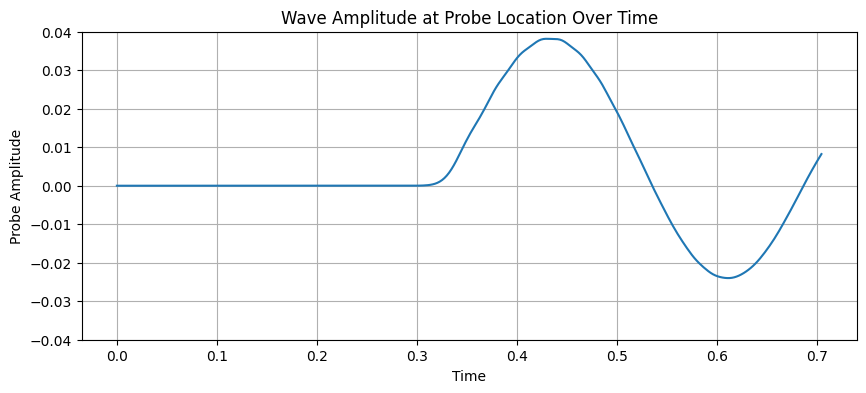

In [ ]:
probe_trace = simulation_output_damping[0, :, 0].detach().numpy()
plt.figure(figsize=(10, 4))
plt.plot(np.arange(num_time_steps) * dt, probe_trace)
plt.xlabel('Time')
plt.ylabel('Probe Amplitude')
plt.ylim(-0.04, 0.04)
plt.title('Wave Amplitude at Probe Location Over Time')
plt.grid(True)
plt.show()

In [ ]:
%%capture
!pip install torch-geometric==2.5.0
!pip install trimesh
!pip install differentiable-voronoi

In [ ]:
from differentiable_voronoi import differentiable_voronoi, triangulate
from shapely import Polygon, LineString, Point
import matplotlib.pyplot as plt
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import to_dense_adj, to_undirected, degree, to_dense_batch
from copy import deepcopy
import numpy as np
from sklearn.cluster import KMeans, SpectralClustering, BisectingKMeans
from trimesh import Trimesh
from scipy.spatial import Delaunay
import matplotlib.patches
from shapely.geometry.polygon import orient
from scipy.spatial import Voronoi, voronoi_plot_2d
from torch_geometric.nn.pool import avg_pool_x
import copy
from torch.nn import MSELoss
from IPython.display import clear_output
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KDTree
from time import sleep

## Graph-based solver

Graph-based solver for unstructured grid operates on graph. We focus on one of the most basic GNN architectures named Message-Passing Neural Networks (MPNN), which is a well-known GNN family that covers a wide range of standard GNN architectures.

The input of a GNN is a graph $G=(V, E)$ -- directed or undirected -- that comprises a set of nodes $V$ and some edges connecting them $E$. Each node v has an associated vector of a predefined size that encodes its state, namely, the node hidden state $h_v$. At the beginning of a GNN execution, hidden state vectors $h_v$ are initialized with some node-related features $x_v$ included in the input graph. Optionally, edges may also contain a set of features denoted by $e_{uv}$ where $u,v \in V$.

Once the hidden states are initialized, a message-passing algorithm is executed according to the connections of the input graph. In this message-passing process, three main phases can be distinguished: (i) Message, (ii) Aggregation, and (iii) Update. First, every node $v \in V$ sends its hidden state to all its neighbors $u \in N(v)$. Then, each node applies the message function $M(·)$ to each of the received messages respectively, to obtain a new more refined representation of the state of its neighbors. After this, every node merges all the computed messages from its neighbors into a single fixed-size vector $m_v$ that comprises all the information. To do this, they use a common Aggregation function (e.g., element-wise summation ). Lastly, every node applies an Update function $U(·)$ that combines its own hidden state $h_v$ with the final aggregated message from the neighbors to obtain its new hidden state. Finally, all this message-passing process is repeated a number of iterations $T$ until the node hidden states converge to some fixed values. Hence, in each iteration, a node potentially receives --- via its direct neighbors --- some information of the nodes that are at k hops in the graph. Formally, the message passing algorithm can be described as:



Message: $\quad m_{vw}^{t+1} = M(h_v^t,h_w^t,e_{v,w}) \\[15pt]$

Aggregation: $\quad m_v^{t+1} = \sum_{w \in N(v)} m_{vw}^{t+1} \\[15pt]$

Update: $\quad h_v^{t+1} = U(h_v^t,m_v^{t+1}) \\[15pt]$

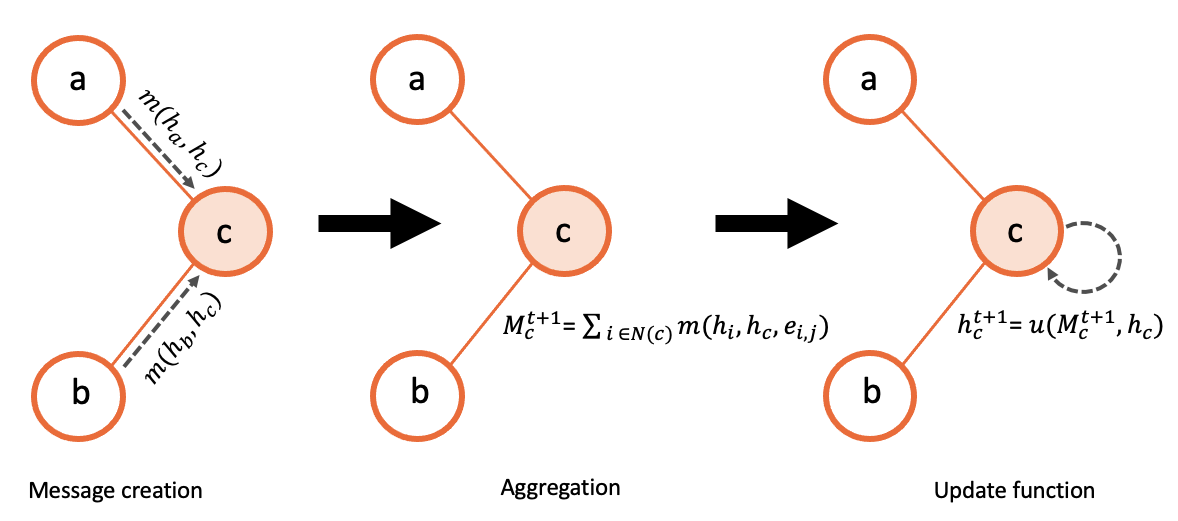

After completing the T message-passing iterations, a Readout function R(·) is used to produce the output of the GNN model. Particularly, this function takes as input the final node hidden states $h^t_v$ and converts them into the output labels of the model $\hat{y}$:

Readout: $\quad \hat{y} = R({h_v^T\ \forall v \in V})$

**PyTorch Geometric** is a library built on PyTorch that provides a simple and efficient way to implement GNNs.  The nodes are represented by their features, often stored in a tensor named `x`, where each row corresponds to a node and its features. The edges are  represented by the `edge_index` tensor. This tensor is of shape `[2, num_edges]` and stores the source and target node indices of each edge format. For example, `edge_index[0, k]` is the index of the source node and `edge_index[1, k]` is the index of the target node for the k-th edge. This representation is crucial for efficiently performing message passing operations.

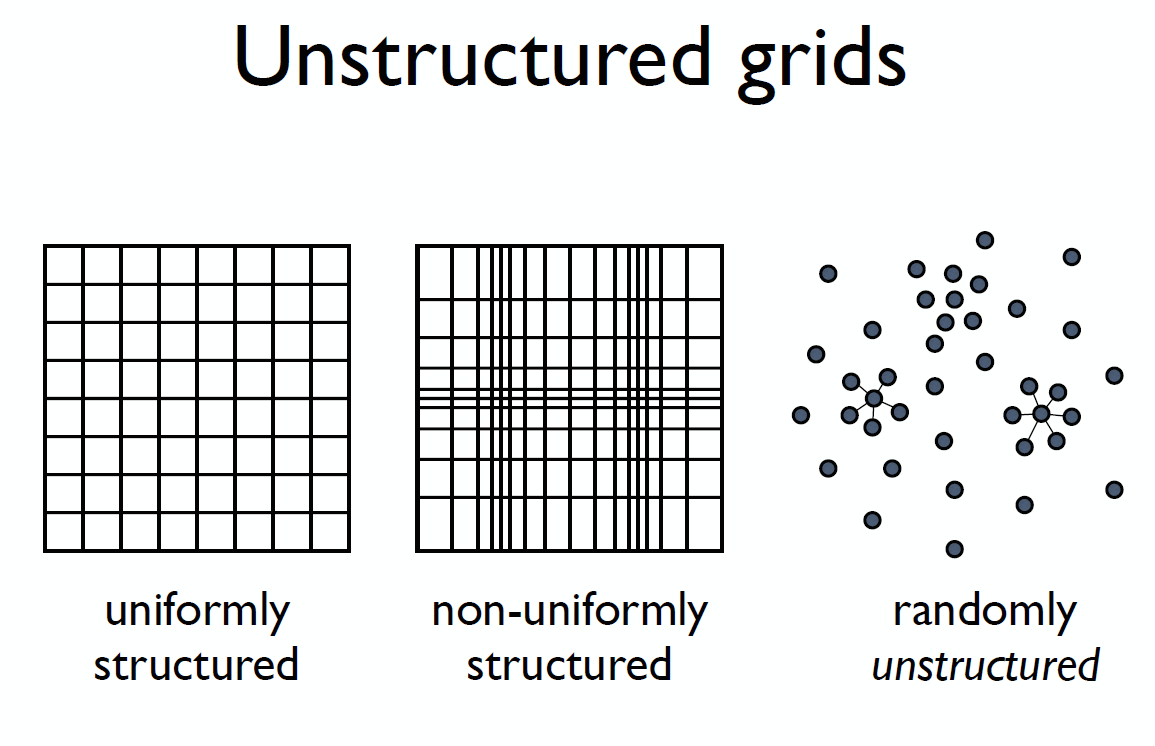

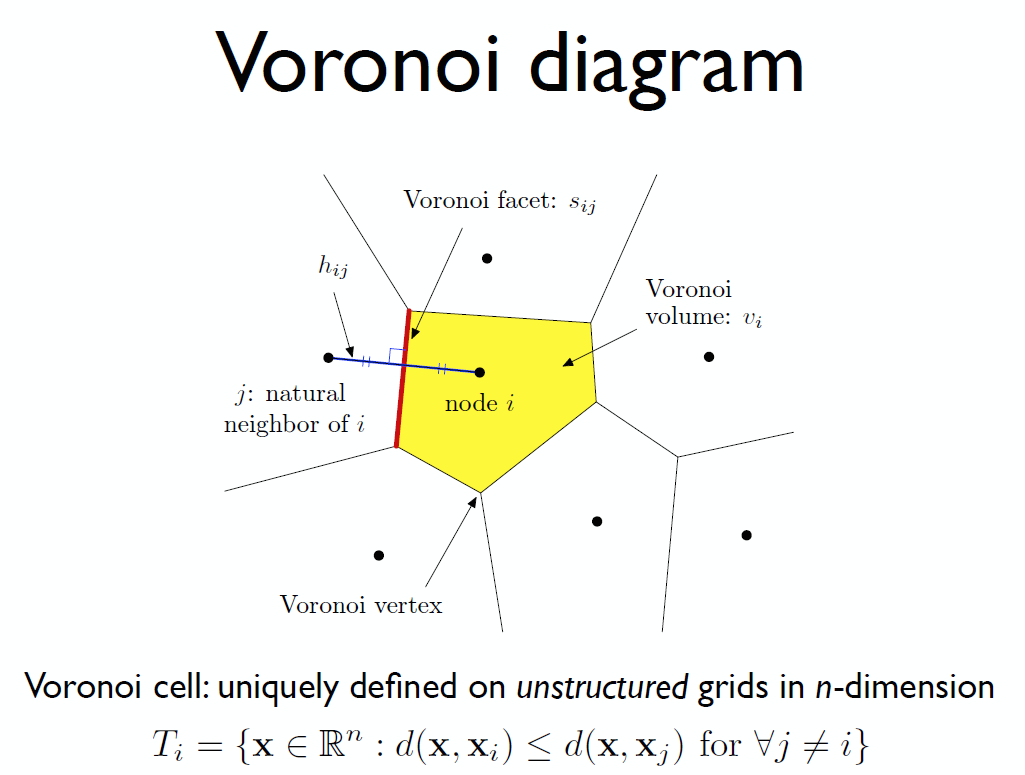

Previously you implemented laplacian for regular grids using 2d regular convolution kernel. But how to implement it using on graph?

$$\nabla^2 u=\lim _{\int_V d \tau \rightarrow 0} \frac{\int_S \boldsymbol{\nabla} u \cdot \mathbf{n} d \sigma}{\int_V d \tau} \text { (Gauss's theorem) } $$

$$\left(\nabla^2 u\right)_i \approx \frac{\int_{S_i} \nabla u \cdot \mathbf{n} d \sigma}{\int_{V_i} d \tau}=\frac{1}{v_i} \int_{S_i} \nabla u \cdot \mathbf{n} d \sigma $$

$$\int_{S_i} \nabla u \cdot \mathbf{n} d \sigma \approx \sum_{j \in \text { neighbors }(i)}(\nabla u \cdot \mathbf{n})_{j i} s_{j i}$$

$$
\begin{aligned}
&\text { The outward normal from } i \text { to } j \text { is aligned with the line of centers; with center distance } h_{j i} \text {, }\\
&(\nabla u \cdot \mathbf{n})_{j i} \approx \frac{u_{t-1, j}-u_{t-1, i}}{h_{j i}} .
\end{aligned}
$$


Discrete laplacian:

$$ \nabla^2 u = (1/v_i) \sum_{j \in \text{neighbors}(i)} \frac{s_{ji}}{h_{ji}} (u_{t-1, j} - u_{t-1, i}) $$

Here:
*   $u_{t-1, i}$ is the scalar wave field value at node $i$ at time step $t-1$.
*   $u_{t-1, j}$ is the scalar wave field value at a neighboring node $j$ at time step $t-1$.
*   $\text{neighbors}(i)$ denotes the set of nodes neighboring node $i$ in the graph.
*   $s_{ji}$ is the length of the Voronoi facet (shared boundary) between nodes $j$ and $i$.
*   $h_{ji}$ is the distance between the Voronoi centers of nodes $j$ and $i$.

This formulation arises from discretizing the Laplacian operator on an unstructured mesh, such as a Voronoi grid, and is related to the Finite Volume Method.

### Task 8: Implement function to compute distances between neighboring points using coords and edge_index

In [ ]:
def calc_h(coords, edge_index):
    x_i, x_j = coords[edge_index[0]], coords[edge_index[1]]
    return torch.norm(x_i - x_j, dim=1)

### Task 9/10: Implement function to compute Voronoi-based edge weights for solver & message function in WaveSolver

In [ ]:
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import to_undirected

class WaveSolver(MessagePassing):
    """Graph solver class for the scalar wave equation with damping."""
    def __init__(self):
        super().__init__(aggr='add', flow='target_to_source')
    def calc_weights(self, s, h):
        """Calculate edge weights based on facet areas and distances."""
        numerator =  s
        denominator = h + 1e-18 # Add small epsilon for numerical stability
        assert numerator.shape == denominator.shape
        return torch.divide(numerator, denominator)

    def forward(self, u_nm1, u, v, h, s, k, f, dt, edge_index):
        """
        Perform a single time step update for the wave field on the graph.

        Parameters
        ----------
        u_nm1 : torch.Tensor
            Scalar wave field at time step t-2.
        u : torch.Tensor
            Scalar wave field at time step t-1.
        v : torch.Tensor
            Voronoi node areas associated with each node.
        h : torch.Tensor
            Distances between Voronoi centers (edge lengths).
        s : torch.Tensor
            Voronoi facet lengths (lengths of the shared boundary between cells).
        k : torch.Tensor
            Wave sound squared (c^2).
        f : torch.Tensor
            Source term (f).
        dt : float
            Temporal step size.
        edge_index : torch.Tensor
            Graph connectivity.

        Returns
        -------
        torch.Tensor
            Scalar wave field at time step t.
        """
        assert ~torch.any(torch.isnan(u))
        assert ~torch.any(torch.isnan(u_nm1))
        assert ~torch.any(torch.isnan(v))
        assert ~torch.any(torch.isnan(h))
        assert ~torch.any(torch.isnan(s))
        assert ~torch.any(torch.isnan(k))
        assert ~torch.any(torch.isnan(f))
        assert len(u) == len(u_nm1) == len(v) == len(k) == len(f)
        assert len(h) == len(s) == edge_index.shape[1]
        # Data type checks
        assert u.dtype == u_nm1.dtype == v.dtype == h.dtype == s.dtype == k.dtype == f.dtype, "All input tensors should have the same dtype."
        assert torch.all(v > 0), "Voronoi volumes (v) must be positive."
        assert torch.all(h > 0), "Distances (h) must be positive."
        assert torch.all(s >= 0), "Facet areas (e) must be non-negative."
        assert torch.all(k > 0), "Wave sound squared (k) must be positive."


        weights = self.calc_weights(s, h).view(-1, 1)
        assert ~torch.any(torch.isnan(weights))
        assert len(weights) == edge_index.shape[1], print(len(weights), len(edge_index))
        assert torch.all(weights >= 0), "Weights must be non-negative."

        # Ensure edge_index and weights are on the same device as input tensors
        edge_index = edge_index.to(u.device)
        weights = weights.to(u.device)

        edge_index, weights = to_undirected(edge_index, weights)

        laplacian = self.propagate(edge_index=edge_index, x=u, weights=weights)/v
        assert len(laplacian) == len(u)

        u_next = -u_nm1 + 2 * u + k * (dt**2) * laplacian + (dt**2) * f

        return u_next

    def message(self, x_i, x_j, weights):
        """
        Message function: computes the message from source node j to target node i.
        """
        du = x_j - x_i
        return weights * du

In [ ]:
# Use the same dimensions and spatial step size as the regular grid experiments
nx, ny = 100, 100
h = 0.01

x = np.linspace(0, (nx - 1) * h, nx)
y = np.linspace(0, (ny - 1) * h, ny)
xv, yv = np.meshgrid(x, y)

point_cloud_np = np.vstack([xv.ravel(), yv.ravel()]).T

COORDS = torch.tensor(point_cloud_np, dtype=torch.float32, requires_grad=False)

print(f"Generated point cloud with shape: {COORDS.shape}")

Generated point cloud with shape: torch.Size([10000, 2])


In [ ]:
min_x, min_y = COORDS.min(dim=0).values.tolist()
max_x, max_y = COORDS.max(dim=0).values.tolist()

L=1.0
eps = 1e-7

# Create the boundary
boundary = torch.tensor([[-eps,-eps],
                                  [-eps, L + eps],
                                   [L + eps, L + eps],
                                    [L + eps, -eps]], requires_grad=False)

print(f"Defined boundary: {boundary}")

Defined boundary: tensor([[-1.0000e-07, -1.0000e-07],
        [-1.0000e-07,  1.0000e+00],
        [ 1.0000e+00,  1.0000e+00],
        [ 1.0000e+00, -1.0000e-07]])


In [ ]:
dt = 0.5 * h / c_const / np.sqrt(2) # Using the same dt as the previous regular grid simulation
num_time_steps = 300 # Using the same number of time steps
source_spatial_location = (nx // 2 * h, ny // 2 * h)
probe_spatial_location = (nx // 6 * h, ny // 6 * h)

coords_np = COORDS.numpy()
kdtree = KDTree(coords_np)

source_index = kdtree.query([source_spatial_location], k=1)[1][0][0]
probe_index = kdtree.query([probe_spatial_location], k=1)[1][0][0]

print(f"Source spatial location: {source_spatial_location}, nearest node index: {source_index}")
print(f"Probe spatial location: {probe_spatial_location}, nearest node index: {probe_index}")

source_strength = 1.0
source_input_signal_graph = torch.sin(torch.linspace(0, 4 * torch.pi, num_time_steps)) * 0.5 * (1/dt ** 2)
sources = {source_index: source_strength} # Dictionary mapping source node index to strength

probes = [probe_index] # List of node indices for probes

Source spatial location: (0.5, 0.5), nearest node index: 5050
Probe spatial location: (0.16, 0.16), nearest node index: 1616


In [ ]:
# Use the generated point cloud and boundary to compute the necessary geometric properties
# (areas, edge_index, h, s) using triangulate and differentiable_voronoi.

mesh = triangulate(COORDS.clone().detach())
edge_index, areas, s, _ = differentiable_voronoi(COORDS, mesh, boundary)

# Calculate edge lengths (h)
h = calc_h(COORDS, edge_index)

c_const = 1.5
k = torch.full((len(COORDS), 1), c_const**2, dtype=COORDS.dtype, device=COORDS.device, requires_grad=True)

source_term_time_dependent = torch.zeros((num_time_steps, len(COORDS), 1), dtype=COORDS.dtype, device=COORDS.device, requires_grad=False)

# Apply the source signal at the source node for each time step
source_node_index = list(sources.keys())[0] # Assuming only one source for now
source_term_time_dependent[:, source_node_index, 0] = source_input_signal_graph

print(f"Computed areas shape: {areas.shape}")
print(f"Computed edge_index shape: {edge_index.shape}")
print(f"Computed h shape: {h.shape}")
print(f"Computed s shape: {s.shape}")
print(f"Defined wave speed squared (k) shape: {k.shape}")
print(f"Defined time-dependent source term shape: {source_term_time_dependent.shape}")

Computed areas shape: torch.Size([10000])
Computed edge_index shape: torch.Size([2, 29601])
Computed h shape: torch.Size([29601])
Computed s shape: torch.Size([29601])
Defined wave speed squared (k) shape: torch.Size([10000, 1])
Defined time-dependent source term shape: torch.Size([300, 10000, 1])


In [ ]:
# Initialize the initial wave field u0.
u0 = torch.zeros((len(COORDS), 1), dtype=COORDS.dtype, device=COORDS.device, requires_grad=False)

print(f"Initialized wave field u0 with shape: {u0.shape}")
graph_wave_solver = WaveSolver()

print("Instantiated WaveSolver.")

print("Running simulation using Graph Wave Solver...")

def roll_out_wave(solver, n_steps, u0, v, h, s, k, source_terms_time_dependent, dt, edge_index, keep=0, save_animation=False, every_nth=1):
    animation = []
    # Initialize roll with the correct shape and type
    if isinstance(keep, int):
        roll = torch.zeros((1, n_steps), dtype=u0.dtype, device=u0.device)
        roll[0, 0] = u0[keep].squeeze()
    elif isinstance(keep, (list, tuple, torch.Tensor)):
        roll = torch.zeros((len(keep), n_steps), dtype=u0.dtype, device=u0.device)
        roll[:, 0] = u0[keep].squeeze()
    else:
        raise TypeError("keep must be an integer, list, tuple, or torch.Tensor")

    # Initialize for the first step (t=1). Assume initial rest state: u_{-1} = u_0
    u_nm1 = u0.clone().detach() # u at t=-1
    u_n = u0.clone().detach() # u at t=0

    if save_animation:
         if every_nth == 1 or 0 % every_nth == 0:
             animation.append(u_n.cpu().numpy().squeeze()) # Squeeze to remove the last dimension


    for i in tqdm(range(1, n_steps)):
        # Get the source term for the current time step (f_{t-1} in the equation)
        # The source_terms_time_dependent tensor is indexed by time step.
        # For computing u_i, we need f_{i-1}, which is at index i-1 in the source_terms_time_dependent tensor.
        f_t_minus_1 = source_terms_time_dependent[i-1, :, :]

        # In iteration i, we compute u_i using u_{i-1} (u_n) and u_{i-2} (u_nm1) and f_{i-1} (f_t_minus_1)
        u_next = solver(u_nm1=u_nm1, u=u_n, v=v.view(-1, 1), h=h, s=s, k=k.view(-1,1), f=f_t_minus_1, dt=dt, edge_index=edge_index) # Corrected variable name from e to s

        # Update for the next iteration
        u_nm1 = u_n
        u_n = u_next

        # Store probe values
        if isinstance(keep, int):
             roll[0, i] = u_n[keep].squeeze()
        elif isinstance(keep, (list, tuple, torch.Tensor)):
             roll[:, i] = u_n[keep].squeeze()

        # Save animation frame
        if save_animation and i % every_nth == 0:
             animation.append(u_n.cpu().detach().numpy().squeeze()) # Squeeze to remove the last dimension

    return roll, animation



graph_simulation_output, graph_animation_frames = roll_out_wave(
    solver=graph_wave_solver,
    n_steps=num_time_steps,
    u0=u0,
    v=areas,
    h=h,
    s=s,
    k=k,
    source_terms_time_dependent=source_term_time_dependent, # Pass the time-dependent source term
    dt=dt,
    edge_index=edge_index,
    keep=probes,
    save_animation=True, # Set to True to save animation frames
    every_nth=1
)

print("Graph simulation finished.")

Initialized wave field u0 with shape: torch.Size([10000, 1])
Instantiated WaveSolver.
Running simulation using Graph Wave Solver...


100%|██████████| 299/299 [00:03<00:00, 76.91it/s]

Graph simulation finished.


In [ ]:
# Visualize results - animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np

print("Creating animation from graph simulation results...")

min_x, min_y = COORDS.min(dim=0).values.tolist()
max_x, max_y = COORDS.max(dim=0).values.tolist()

fig, ax = plt.subplots(figsize=(8, 8))

grid_x, grid_y = np.mgrid[min_x:max_x:100j, min_y:max_y:100j] # Create a 100x100 grid
from scipy.interpolate import griddata

points = COORDS.cpu().numpy()

initial_wave_field = graph_animation_frames[0]
grid_z = griddata(points, initial_wave_field.ravel(), (grid_x, grid_y), method='cubic') # Use ravel() to flatten the node values

im = ax.imshow(grid_z.T, origin='lower', cmap='RdBu', vmin=-0.1, vmax=0.1,
               extent=[min_x, max_x, min_y, max_y])
plt.colorbar(im, label='Amplitude')
ax.set_title('Graph Wave propagation simulation')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal', adjustable='box')

ax.plot(source_spatial_location[0], source_spatial_location[1], 'wo', markersize=8, label='Source')
ax.plot(probe_spatial_location[0], probe_spatial_location[1], 'go', markersize=8, label='Probe')
ax.legend()

every_nth = 1 # Assuming every_nth was 1 in the roll_out_wave call

def animate(i):
    # Get the wave field for the current frame
    wave_field = graph_animation_frames[i]
    # Interpolate the wave field onto the regular grid
    grid_z = griddata(points, wave_field.ravel(), (grid_x, grid_y), method='linear')
    # Update the image data
    im.set_array(grid_z.T)
    ax.set_title(f'Graph Wave propagation simulation | Time Step {i * every_nth + 1}') # Adjust time step display based on every_nth
    return [im]

num_animation_frames = len(graph_animation_frames)
ani = animation.FuncAnimation(fig, animate, frames=num_animation_frames, interval=50, blit=True)

plt.close(fig) # Close the figure to prevent it from displaying twice

print("Animation created. Displaying video...")
# Display the animation as an HTML5 video
display(HTML(ani.to_html5_video()))

Creating animation from graph simulation results...
Animation created. Displaying video...


In [ ]:
# test backpropagation after the graph-based grid simulation

final_wave_field = graph_simulation_output[0, :]

loss = final_wave_field.sum()

print(f"Calculated a simple loss: {loss.item()}")

try:
    loss.backward()
    print("Backward pass completed.")

except RuntimeError as e:
    print(f"Error during backward pass: {e}")
    print("Ensure that at least one tensor in the computation graph requires gradients for backward() to work.")

Calculated a simple loss: 58.10655212402344
Backward pass completed.


In [ ]:
print(k.grad)

tensor([[0.0180],
        [0.0371],
        [0.0360],
        ...,
        [0.0000],
        [0.0000],
        [0.0000]])


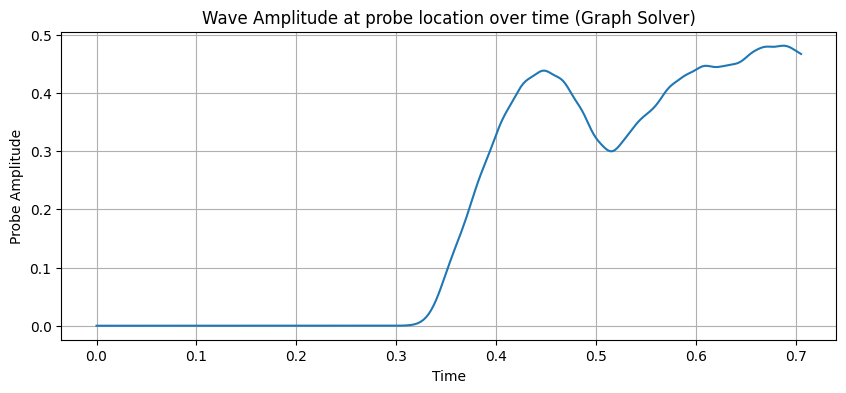

In [ ]:
probe_trace_graph = graph_simulation_output[0, :].detach().numpy()

plt.figure(figsize=(10, 4))
plt.plot(np.arange(num_time_steps) * dt, probe_trace_graph)
plt.xlabel('Time')
plt.ylabel('Probe Amplitude')
plt.title('Wave Amplitude at probe location over time (Graph Solver)')
plt.grid(True)
plt.show()

## Conclusion and next steps

Congratulations! We have successfully implemented and experimented with both a regular grid solver and a graph-based solver for the scalar wave equation. A key advantage of the graph-based solver is its ability to handle **unstructured grids**. While we tested it on a point cloud generated from a regular grid, its true power lies in its applicability to irregular arrangements of points.

Here are some recommendations for further exploration:

1.  **Experiment with unstructured grids**
2.  **Visualize Voronoi grid**
3.  **Implement damping in graph solver:** Extend the `WaveSolver` to include the damping term (as we did previously).
4.  **Boundary conditions in graph solver:** Investigate more sophisticated ways to handle different boundary conditions (like Dirichlet) in the graph-based solver, potentially by modifying the Laplacian calculation for boundary nodes or using ghost nodes.
5.  **Parameter learning:** Utilize the differentiability of the solvers (especially the regular grid one where backprop is working) to learn parameters of the simulation, such as the wave speed distribution `c`, by defining a loss function based on probe measurements and using optimization.
6.  **Further study of differentiable simulators:** Explore other examples and applications of differentiable simulators in various fields and learn about more advanced techniques for building and training them.